In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

Current working directory:  c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_102,
    FILE_PATH_CASE_102b_HFM_T,
    FILE_PATH_CASE_102b_HFM_T_OBS,
    FILE_PATH_CASE_102b_HFM_Z,
    RHEOLOGY_DATA_CASE_102_PATH,
    FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES,
    FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS,
    FILE_PATH_TRANSIENT_OTHER_VARIABLES_102b
)

from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    map_pars_t_z,
    extract_time_series_from_depth_data_for_given_variables,
    get_herschel_bulkley_parameters_from_rheology_file,
    get_training_dataset_from_field_data_transients
)

sns.set_theme()

In [4]:
# Loading files
sensor_data_case_102 = pd.read_pickle(FILE_PATH_CASE_102)
# Extracting the dates to consider
tstamp_min = '2020-08-13 16:20:00+00:00'
tstamp_max = '2020-08-15 01:40:00+00:00'
sensor_data_case_102 = sensor_data_case_102.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data_case_102 = sensor_data_case_102.iloc[1:] 
hfm_data_case_102_t = pd.read_pickle(FILE_PATH_CASE_102b_HFM_T)
hfm_data_case_102_t_obs = pd.read_pickle(FILE_PATH_CASE_102b_HFM_T_OBS)
hfm_data_case_102_z = pd.read_pickle(FILE_PATH_CASE_102b_HFM_Z)


In [5]:
# Getting the indices for the model data right
start_date = '2020-08-13 16:20:00+00:00'
date_range = pd.date_range(start = start_date, periods = len(hfm_data_case_102_t), freq='10s')
hfm_data_case_102_t.index = date_range
# hfm_data_case_102_t_obs.index = date_range
hfm_data_case_102_t.head()
hfm_data_case_102_t.columns

Index(['Rate_in', 'SPP', 'ECD_bot', 'ECD_shoe', 'P_choke', 'FrontFluid2',
       'FrontFluid3', 'FrontFluid4', 'FrontFluid5', 'FrontFluid6', 'totVolInj',
       'totStrokes', 'totVolOut', 'pitVol', 'WHP', 'volRateOut', 'dsGap',
       'BHP', 'T_bot', 'T_top', 'mdBit', 'ecdAtPos', 'pAtPos', 'TAtPos',
       'dsRpm', 'rop', 'xFactor', 'kFactor', 'yCalc', 'yCalcAvg', 'yMeas',
       'Pxy', 'Pyy', 'Pa', 'Gel1', 'Gel2', 'Gel3', 'Gel4', 'Gel5', 'ShieldBHA',
       'ShieldAnn', 'ShieldRiser', 'CtrBHA', 'CtrAnn', 'CtrRiser',
       'CutConsBHA', 'CutConsAnn', 'CutConsRiser', 'ReynBHA', 'ReynAnn',
       'ReynRiser', 'TaylBHA', 'TaylAnn', 'TaylRiser', 'RouseBHA', 'RouseAnn',
       'RouseRiser', 'voidShoe', 'voidAtBha', 'cutSt', 'vDev', 'pDev',
       'mTotMud', 'mFreeGas', 'mDGas', 'qLoss', 'mLost', 'XFactor',
       'DSXFactor', 'DensityIn', 'DensityOut'],
      dtype='object')

In [6]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t))
sensor_data_case_102.head()

12000 12000


,WOB,HKLD,MUD_FLOW_OUT,BLOCKPOS,ROP,TORQ,MUD_FLOW_IN,MUD_DENS_OUT,PUMP_PRESS,PIT_TOT,...,D1AX-Relog,D1AY-Relog,PWPI-Relog,EAAF-Relog,DGRCC-Relog,PW16-Relog,D1SS-Relog,ALCDH-Relog,RDGDTVSS-Relog,D1AZ-Relog
TIME,,,,,,,,,,,,,,,,,,,,,
2020-08-13 16:20:10+00:00,0.0,9.693974e+05,0.0,37.427332,0.0,34.091530,0.0,1158.730149,253639.163971,153.343582,...,1.2,1.2,390.912506,1.296844,35.94529,4180.0,125.0,0.0,80.0,15.2
2020-08-13 16:20:20+00:00,0.0,1.082254e+06,0.0,37.062952,0.0,32.754644,0.0,1158.730149,253203.716278,153.248840,...,1.2,1.2,390.912506,1.296844,35.94529,4180.0,125.0,0.0,80.0,15.2
2020-08-13 16:20:30+00:00,0.0,1.150152e+06,0.0,27.982082,0.0,37.037300,0.0,1151.643992,254392.375946,153.248840,...,1.2,1.2,390.912506,1.296844,35.94529,4180.0,125.0,0.0,80.0,15.2
2020-08-13 16:20:40+00:00,0.0,1.178021e+06,0.0,10.258865,0.0,59.544824,0.0,1151.643992,258809.695244,153.248840,...,1.2,1.2,390.912506,1.296844,35.94529,4180.0,125.0,0.0,80.0,15.2
2020-08-13 16:20:50+00:00,0.0,1.137403e+06,0.0,1.322652,0.0,71.082319,0.0,1151.643992,258164.296150,153.222122,...,1.2,1.2,390.912506,1.296844,35.94529,4180.0,125.0,0.0,80.0,15.2


In [7]:

# sensor_data_case_102, hfm_data_case_102_t = get_active_drilling_data(sensor_data_case_102, hfm_data_case_102_t, include_rop_zeros=True)
# Wait to get obs data. Not sure if it is necassary
# hfm_data_case_102_t_obs = hfm_data_case_102_t_obs.loc[hfm_data_case_102_t.index]

In [8]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t),len(hfm_data_case_102_t_obs))
hfm_data_case_102_t.index = sensor_data_case_102.index
hfm_data_case_102_t_obs.index = sensor_data_case_102.index

12000 12000 12000


In [9]:
min_depth = 0 
max_depth = 5820

depth_data =  hfm_data_case_102_z[0]
depth_data_columns = hfm_data_case_102_z[1] 

In [10]:
asm_sensor_1 = sensor_data_case_102["ASMDEP1-T"]
asm_sensor_1 = asm_sensor_1.iloc[1:]

In [11]:
values_for_position = extract_time_series_from_depth_data_for_given_variables(depth_data=depth_data, position_for_time_series=asm_sensor_1.values,columns=depth_data_columns)

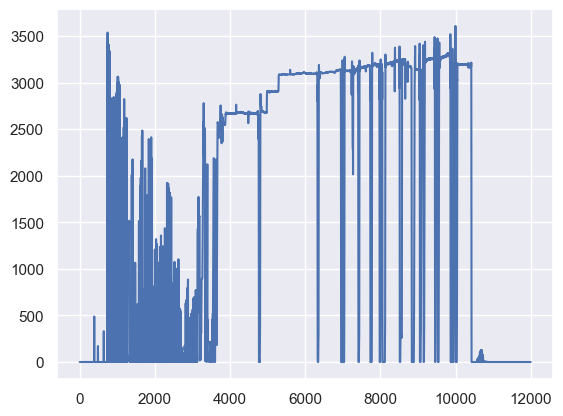

In [12]:
plt.plot(values_for_position["reyn"])
plt.show()

In [13]:

# m / s^2
gravitational_constant = 9.80
# m
DH = 0.06985
# m
charecteristic_length = 0
liquid_velocities = values_for_position["vL"]
pressure_gradient = values_for_position["dpf"]
# Unsure if this densisty value is the correct one
fluid_density = values_for_position["avgDensity"]
pressure = values_for_position["pOut/pBar"]
# Value blows up when there is little flow. Don't think this will be a problem during steady state conditions
fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)
values_for_position["Friction factor"] = fanning


C:\Users\thomaswi\AppData\Local\Temp\ipykernel_1232\3727425899.py:13: RuntimeWarning: divide by zero encountered in divide
  fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_1232\3727425899.py:13: RuntimeWarning: invalid value encountered in divide
  fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)


In [14]:
inclination = np.arccos(hfm_data_case_102_t_obs["TvdAtPpos1"].diff() /  hfm_data_case_102_t["mdBit"].diff()) * 180 / np.pi

c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


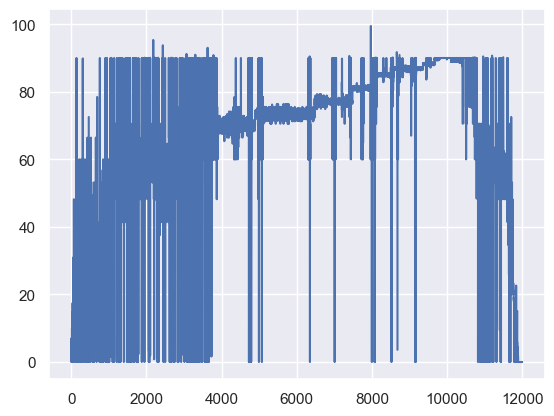

In [15]:
# Visual inspection provides us with the knowledge that the inclination is 
# 90 degrees during the entire drilling operation

plt.plot(inclination.values)


In [16]:
# These are the transients
indices_case_102 = [1152,2883,3364,4473,4800]

In [17]:
values_for_position_df = pd.DataFrame(values_for_position)
sensor_data_case_102 = sensor_data_case_102.iloc[1:]
values_for_position_df.index = sensor_data_case_102.index
_, df_simulated = get_active_drilling_data(sensor_data_case_102, sim_df=hfm_data_case_102_t_obs ,include_rop_zeros=True)
drilling_sensor_data_case_102, values_for_position_df = get_active_drilling_data(sensor_data_case_102, sim_df=values_for_position_df ,include_rop_zeros=True)

In [18]:
print(len(drilling_sensor_data_case_102))

5942


In [19]:
hb_parameters = get_herschel_bulkley_parameters_from_rheology_file(RHEOLOGY_DATA_CASE_102_PATH) 
hb_parameters.head(11)    

,Temperature,Pressure,Consistency index (K),Yield stress (tau_y),Flow behaviour index (n)
0,50.0,1.0,0.902249,0.064411,0.796957
1,50.0,103.0,1.145990,0.038647,0.887717
2,70.0,138.0,1.363140,0.054337,0.819334
3,70.0,172.0,1.357320,0.056890,0.820349
4,100.0,207.0,1.656580,0.072227,0.772995
5,100.0,241.0,1.593770,0.057289,0.814421
6,120.0,276.0,1.530710,0.071310,0.768217
7,120.0,310.0,1.500920,0.050376,0.821522
8,120.0,345.0,1.350200,0.051985,0.806962
9,120.0,414.0,1.348380,0.047958,0.827776


In [20]:
values_for_position_df.head()
yield_stress = []
consistency_index = []
flow_behaviour_index = []
temperature_regions = values_for_position_df["TOut"].apply(lambda x: 2 if x > 85 else (1 if x > 60 else 0))
hb_parameters_for_case = np.array([hb_parameters.loc[5] if t_region == 2 else (hb_parameters.loc[3] if t_region == 1 else hb_parameters.loc[1]) for t_region in temperature_regions])

print('Min and max temp: ',values_for_position_df["TOut"].min(),values_for_position_df["TOut"].max())
print('Min and max pressure: ',values_for_position_df["pOut/pBar"].min(),values_for_position_df["pOut/pBar"].max()) 

print(len(liquid_velocities))
print(len(hb_parameters_for_case))
    

Min and max temp:  23.877471322332507 95.64866666666667
Min and max pressure:  32.01273548562127 293.6166666666667
11999
5942


In [21]:
# Adding new parameters and interaction terms
values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_1232\1973994747.py:2: RuntimeWarning: invalid value encountered in power
  values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])


In [22]:
# The annulus is assumed fully conccentric when inclination is 90 degrees
variables_1 = ["reyn","tayl","Bingham number","Friction factor", "rouseNum", "shieldsNum"]
variables = variables_1
training_features, training_targets, other_variables = get_training_dataset_from_field_data_transients(df=values_for_position_df,df_simulated=df_simulated,df_sensor = drilling_sensor_data_case_102,target = "ASMECD1-T",variables=variables, indices = indices_case_102, window = 20)


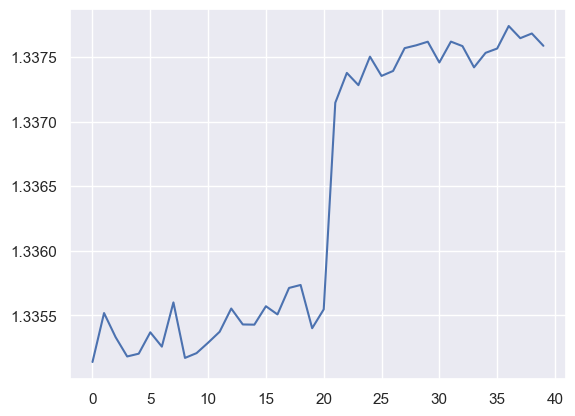

In [23]:
plt.plot(training_targets[0,:])

In [24]:
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES, 'wb') as file:
    pickle.dump(training_features, file)

with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS, 'wb') as file:
    pickle.dump(training_targets, file)

with open(FILE_PATH_TRANSIENT_OTHER_VARIABLES_102b, 'wb') as file:
    pickle.dump(other_variables, file)